**Подключение библиотек и скриптов**

In [276]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input\real-estate-price-prediction-moscow\test.csv
/kaggle/input\real-estate-price-prediction-moscow\train.csv


In [277]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Подключение предупреждений

In [278]:
import warnings
warnings.filterwarnings('ignore')

Приводим к единому стандарту оформления шрифтов

In [279]:
matplotlib.rcParams.update({'font.size': 14})

Задаем функцию уменьшения обьема данных

In [280]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

Задаем функцию подсчёта метрик

In [281]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

#### **Загрузка данных**




**Описание датасета**

   - **Id** - идентификационный номер квартиры
   - **DistrictId** - идентификационный номер района
   - **Rooms** - количество комнат
   - **Square** - площадь
   - **LifeSquare** - жилая площадь
   - **KitchenSquare** - площадь кухни
   - **Floor** - этаж
   - **HouseFloor** - количество этажей в доме
   - **HouseYear** - год постройки дома
   - **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
   - **Social_1, Social_2, Social_3** - социальные показатели местности
   - **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
   - **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
   - **Price** - цена квартиры



Загрузим данные и применим функцию reduce_mem_usage для уменьшения их объема.

In [282]:
train_df = pd.read_csv('train.csv')
train_df = reduce_mem_usage(train_df)
train_df.head()

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.718750
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.093750


In [283]:
train_df.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

In [284]:
test_df = pd.read_csv('test.csv')
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [285]:
train_df.shape

(10000, 20)

In [286]:
test_df.shape

(5000, 19)

Количество строк в тесте и трейне

In [287]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


In [288]:
train_df.shape[1] - 1 == test_df.shape[1]

True

#### **Приведение типов**

Приводим типы данных признаков 'Id' и 'DistrictId' в категориальные

In [289]:
train_df['Id'] = train_df['Id'].astype('category')
train_df['DistrictId'] = train_df['DistrictId'].astype('category') 

#### **1. EDA**

#### **Целевая переменная.**

Строим гистограмму, чтобы визуализировать распределение таргета.

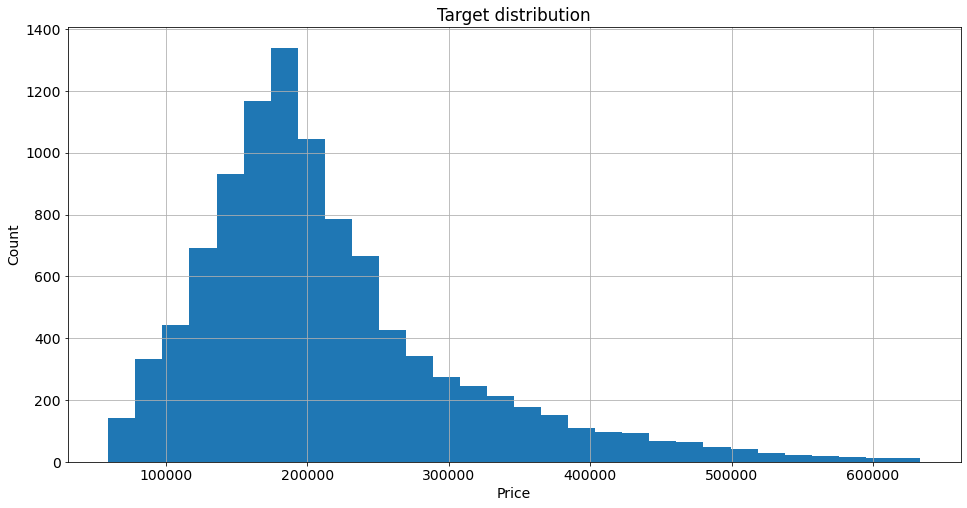

In [290]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

Распределение равномерное. Выбросы не наблюдаем.

#### **Количественные переменные**

In [291]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rooms,10000.0,1.890500,0.839522,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315720,21.058716,1.136859,41.774879,52.513309,65.900627,6.410652e+02
LifeSquare,7887.0,37.199665,86.241219,0.370619,22.769833,32.781261,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560839,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.776200,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218670e-01
Social_1,10000.0,24.687000,17.532614,0.000000,6.000000,25.000000,36.000000,7.400000e+01
Social_2,10000.0,5352.157400,4006.799803,168.000000,1564.000000,5285.000000,7227.000000,1.908300e+04


Видим пропуски и аномалии в цифрах(выбросы).

#### **Номинативные переменные**

In [292]:
train_df.select_dtypes(include='category').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [293]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
174      1
205      1
207      1
117      1
209      1
Name: DistrictId, Length: 205, dtype: int64

In [294]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [295]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [296]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

#### **2. Обработка выбросов**

**Rooms**

In [297]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Создадим вспомогательный признак 'Rooms_outlier' и заполним его 0, a где кол-во комнат == 0 и >= 6 заполним 1.

In [298]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.875000,0
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.546875,0
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.718750,0
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.000000,0
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.093750,0


Заменяем значение признака 'rooms' на 1, если он был равен 0, и на медианное значение, если он был равен или больше 6.

In [299]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

In [300]:
train_df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

**Square**

Рассмотрим распределение признака 'Square' на гистограмме

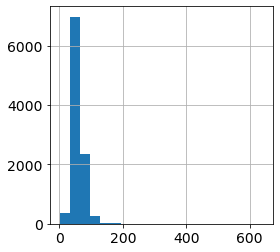

In [301]:
train_df['Square'].hist(figsize=(4,4), bins=20);

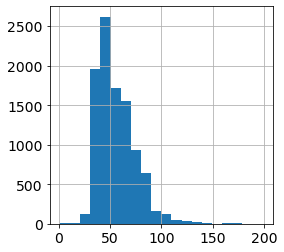

In [302]:
train_df.loc[train_df['Square'] < 200, 'Square'].\
    hist(figsize=(4,4), bins=20);

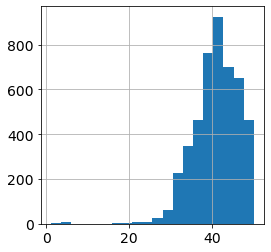

In [303]:
train_df.loc[train_df['Square'] < 50, 'Square'].\
    hist(figsize=(4,4), bins=20);

Рсапределение признака равномерно в диапазоне от 20 до 150.

Заполняем неадекватные значения в признаке 'Square'.

Квартиры больше 150 м2 и квартиры меньше 20 м2 считаем выбросами и заполняем их медианами,



In [304]:
condition = (train_df['Square'].isna()) \
             | (train_df['Square'] > 150) \
             | (train_df['Square'] < 20)
        
train_df.loc[condition, 'Square'] = train_df['Square'].median()

**KitchenSquare**

In [305]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
30.0         2
43.0         2
41.0         2
112.0        2
25.0         2
51.0         2
37.0         2
58.0         2
32.0         2
21.0         1
73.0         1
75.0         1
36.0         1
27.0         1
63.0         1
1970.0       1
54.0         1
53.0         1
60.0         1
26.0         1
66.0         1
39.0         1
29.0         1
78.0         1
31.0         1
84.0         1
48.0         1
96.0         1
42.0         1
40.0         1
23.0         1
72.0         1
35.0         1
62.0         1
123.0        1
2014.0       1
Name: KitchenSquare, dtype: int64

In [306]:
train_df['KitchenSquare'].quantile(.975), train_df['KitchenSquare'].quantile(.025)

(13.0, 0.0)

Заполняем неадекватные значения в признаке 'KitchenSquare'.

Кухни больше 13 м2 (квантиль 97,5%) и кухни меньше 5м2 считаем выбросами и заполняем их медианами.

In [307]:
condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975)) \
             | (train_df['KitchenSquare'] < 5)
        
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

In [308]:
train_df['KitchenSquare'].value_counts()

6.0     4449
8.0     1306
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
Name: KitchenSquare, dtype: int64

**Floor, HouseFloor**

Рассмотрим уникальные значения признаков Floor и HouseFoor

In [309]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int8)

In [310]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.],
      dtype=float32)

Есть дома с нулевой этажностью - выброс

Сопоставим этаж и количество этажей в доме

In [311]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

Получаем 1825 квартир, у которых этаж больше, чем этажность - выброс 

Создадим вспомогательный признак 'HouseFloor_outlier' и заполним его 0, a где этажность == 0 и > 90, а также этаж квартиры > этажности 1.

In [312]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[(train_df['HouseFloor'] == 0) | (train_df['HouseFloor'] > 90), 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

Заполним значения в признаке 'HouseFloor' равные нулю и больше 90 на медиану

In [313]:
train_df.loc[(train_df['HouseFloor'] == 0) | (train_df['HouseFloor'] > 90), 'HouseFloor'] = train_df['HouseFloor'].median()

Извлечем индексы квартир, у которых этаж больше этажности дома

In [314]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)

По индексам заполним значения в признаке 'Floor' на случайные из диапазона значений признака 'HouseFloor'

In [315]:
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))

In [316]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

**HouseYear**

In [317]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int32

Видим неадекватные значения превышающие текущую дату - выбросы

Рассмотрим какому значению соответствует наибольшее количество квартир и заменим выбросы на это значение.

In [318]:
train_df['HouseYear'].value_counts().head(1)

1977    2652
Name: HouseYear, dtype: int64

In [319]:
train_df.loc[train_df['HouseYear'] > 2021, 'HouseYear'] = 1977

#### **3. Обработка пропусков**

In [320]:
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
HouseFloor_outlier       0
dtype: int64

Видим два признака с пропусками 'LifeSquare' и 'Healthcare_1'

**LifeSquare**

Жилая площадь квартиры = общая площадь - площадь кухни - 7 м2 (санузел, кладовая, коридоры)

Создадим новый признак 'LifeSquare_nan' и заполним пропуски 1

In [321]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

Заполним пропуски в признаке 'LifeSquare'

In [322]:
condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
        
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare'] - 7

Квартиры c жилой площадью больше 140 м2 и квартиры меньше 7 м2 считаем выбросами и заполняем их медианами

In [323]:
condition = (train_df['LifeSquare'].isna()) \
             | (train_df['LifeSquare'] > 140) \
             | (train_df['LifeSquare'] < 7)
        
train_df.loc[condition, 'LifeSquare'] = train_df['LifeSquare'].median()

Посмотрим количество квартир, жилая площадь которых превышает общую.

In [324]:
(train_df['LifeSquare'] > train_df['Square']).sum()

475

Видим что у нас есть неадекватные значения - выбросы

Извлечем индексы квартир, жилая площадь которых превышает общую.

In [325]:
square_outliers = train_df.loc[train_df['LifeSquare'] > train_df['Square']].index
square_outliers

Int64Index([  33,   64,   77,  100,  111,  142,  165,  179,  213,  262,
            ...
            9825, 9831, 9841, 9873, 9947, 9960, 9962, 9979, 9987, 9993],
           dtype='int64', length=475)

Используя индексы поменяем местами значения признаков 'LifeSquare' и 'Square'.

In [326]:
train_df.loc[square_outliers, 'LifeSquare'],train_df.loc[square_outliers, 'Square'] \
                          = train_df.loc[square_outliers,'Square'],train_df.loc[square_outliers, 'LifeSquare']
                                               

In [327]:
(train_df['LifeSquare'] > train_df['Square']).sum()

0

**Healthcare_1**

Заполним пропуски значением медианы

In [328]:
train_df['Healthcare_1'] = train_df['Healthcare_1'].median()

In [329]:
train_df.isna().sum()

Id                    0
DistrictId            0
Rooms                 0
Square                0
LifeSquare            0
KitchenSquare         0
Floor                 0
HouseFloor            0
HouseYear             0
Ecology_1             0
Ecology_2             0
Ecology_3             0
Social_1              0
Social_2              0
Social_3              0
Healthcare_1          0
Helthcare_2           0
Shops_1               0
Shops_2               0
Price                 0
Rooms_outlier         0
HouseFloor_outlier    0
LifeSquare_nan        0
dtype: int64

Видим, что пропусков нет

#### **4. Оформим обработку выбросов, пропусков  и генерацию новых признаков через class DataPre**

In [330]:
class DataPre:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        self.healthcare_1_median = None
        self.binary_to_numbers = None
        self.district_size = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
        self.healthcare_1_median = X['Healthcare_1'].median()
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # Square
        condition = (X['Square'].isna()) \
             | (X['Square'] > 150) \
             | (X['Square'] < 20)
        
        X.loc[condition, 'Square'] = self.medians['Square']
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
             | (X['KitchenSquare'] > self.kitchen_square_quantile) \
             | (X['KitchenSquare'] < 5)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[(X['HouseFloor'] == 0) | (X['HouseFloor'] > 90), 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[(X['HouseFloor'] == 0) | (X['HouseFloor'] > 90), 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = 1977
        
        # Healthcare_1
        X['Healthcare_1'] = X['Healthcare_1'].fillna(self.healthcare_1_median)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 7
        
        condition = (X['LifeSquare'].isna()) \
             | (X['LifeSquare'] > 140) \
             | (X['LifeSquare'] < 7)
        
        X.loc[condition, 'LifeSquare'] = self.medians['LifeSquare']
        
        square_outliers = X.loc[X['LifeSquare'] > X['Square']].index
        
        X.loc[square_outliers, 'LifeSquare'],X.loc[square_outliers, 'Square'] \
                          = X.loc[square_outliers,'Square'],X.loc[square_outliers, 'LifeSquare']
        
        """Генерация новых фич"""
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        X.fillna(self.medians, inplace=True)
                                                
        return X

In [331]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

**Инициализация класса DataPre**

In [332]:
data_inst = DataPre()
data_inst.fit(train_df)
train_df = data_inst.transform(train_df)

#### **5. Отбор признаков** 

In [333]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'HouseYear_outlier',
 'LifeSquare_nan',
 'DistrictSize',
 'new_district',
 'IsDistrictLarge']

In [334]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
                     'new_district', 'IsDistrictLarge']

target_name = 'Price'

#### **6. Разбиение на train и test**

In [335]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [336]:
X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [337]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [338]:
prep = DataPre()
prep.fit(X_train)

X_train = prep.transform(X_train)
X_valid = prep.transform(X_valid)
test_df = prep.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 26), (3300, 26), (5000, 26))

In [339]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [340]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

#### **7. Построение модели**

**Обучение**

In [341]:
model = GradientBoostingRegressor(criterion='mse', 
                                     max_depth=5,
                                     min_samples_leaf=9,
                                     random_state=42,  
                                     n_estimators=200)
model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=5, min_samples_leaf=9,
                          n_estimators=200, random_state=42)

Train R2:	0.883
Test R2:	0.754


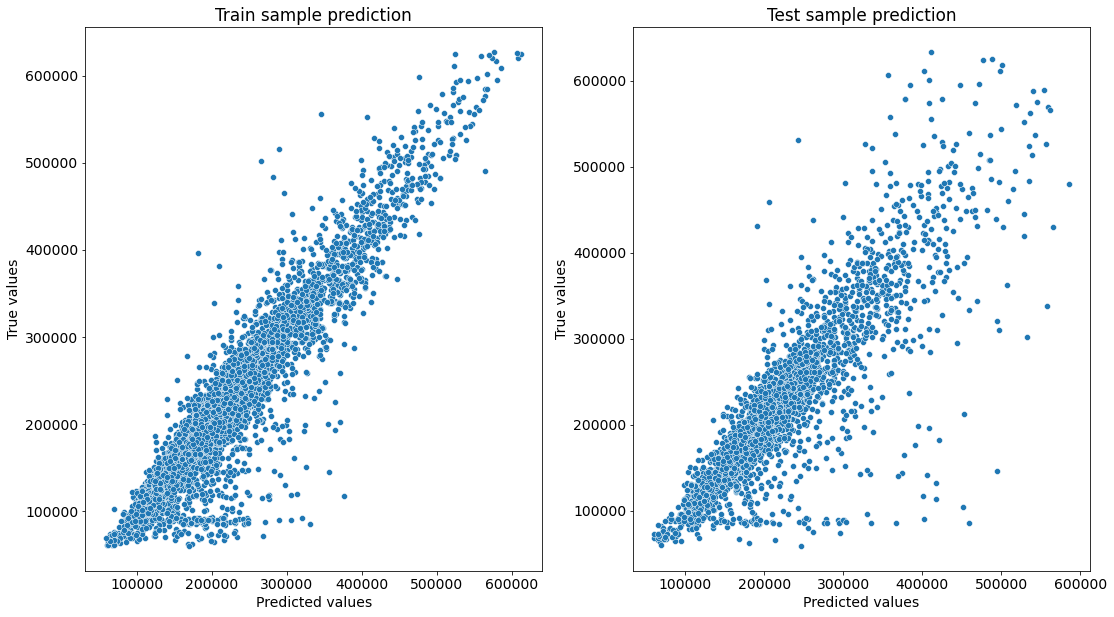

In [342]:
y_train_preds = model.predict(X_train)
y_test_preds = model.predict(X_valid)
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

**Важность признаков**

In [343]:
feature_importances = pd.DataFrame(zip(X_train.columns, model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.443816
20,DistrictSize,0.237058
12,Social_3,0.057492
11,Social_2,0.042280
7,Ecology_1,0.037882
0,Rooms,0.034613
6,HouseYear,0.029025
2,LifeSquare,0.026132
10,Social_1,0.023721
5,HouseFloor,0.020972


#### **8. Прогнозирование на тестовом датасете**

In [344]:
test_df.shape

(5000, 23)

In [345]:
test_df

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Helthcare_2,Shops_1,Shops_2,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,new_district,IsDistrictLarge
0,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,1,1,...,1,1,1,0,0,0,0,76.0,0,0
1,1.0,42.568133,42.493907,10.0,7,17.0,2017,0.072158,1,1,...,0,0,0,0,0,0,0,164.0,0,1
2,2.0,59.463678,43.463678,9.0,19,19.0,1977,0.211401,1,1,...,0,1,1,0,0,0,1,580.0,0,1
3,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,1,1,...,0,0,1,0,0,0,0,372.0,0,1
4,1.0,53.837056,40.837056,6.0,8,17.0,1977,0.309479,1,1,...,0,6,1,0,0,0,1,65.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.0,43.177521,30.339945,5.0,2,5.0,1962,0.069660,1,1,...,1,2,1,0,1,0,0,56.0,0,0
4996,3.0,94.521465,93.698122,10.0,21,27.0,2018,0.060753,1,1,...,0,7,1,0,0,0,0,26.0,0,0
4997,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,1,1,...,2,5,1,0,0,0,0,54.0,0,0
4998,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,1,1,...,0,11,1,0,0,0,0,40.0,0,0


In [347]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [348]:
predictions = model.predict(test_df)
predictions

array([163738.19842899, 127043.53013376, 146542.40554511, ...,
       146949.71237612, 193655.3412705 , 243999.43142755])

In [349]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,163738.198429
1,5925,127043.530134
2,960,146542.405545
3,3848,142405.472404
4,746,205282.688789


In [350]:
submit.to_csv('submit.csv', index=False)